In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.animation as animation
import glob, re, os
import pandas as pd

import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
# Don't use cuda with keras
keras.backend.clear_session()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

2023-03-12 17:00:01.443082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 17:00:01.657737: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-12 17:00:01.701121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/remi/software:
2023-03-12 17:00:01.701141: I tensorflow/compiler/xla/stream_executor/cud

In [2]:
def plot_loss(history, ax):
    """ Plot the loss function. """
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.grid(True)

In [3]:
dataset_path_dir = "../../build/DATASET_COMPLEX_SPAD/"
list_of_files = glob.glob(dataset_path_dir + "*.csv")
latest_file = max(list_of_files, key=os.path.getctime)
dataset_path = latest_file
print("Dataset path: ", dataset_path)
df = pd.read_csv(dataset_path, sep=",", header=0)

idx_BV = df.columns.get_loc("BreakdownVoltage")
idxBrP = idx_BV + 1
idxDW = idx_BV + 2
idxDoping = np.arange(1, idx_BV, 1)
print(idxDoping)

Dataset path:  ../../build/DATASET_COMPLEX_SPAD/dataset_complex_2023-03-09_18-40-29.csv
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


In [4]:
# Drop NaN values
df = df.dropna()
df.tail()

# The columns in idxDoping must be log10 transformed and the sign kept
df.iloc[:, idxDoping] =np.log10(df.iloc[:, idxDoping])

df.tail()

,TotalLength,Donor_0,Donor_1,Donor_2,Donor_3,Donor_4,Donor_5,Donor_6,Donor_7,Donor_8,...,Acceptors_93,Acceptors_94,Acceptors_95,Acceptors_96,Acceptors_97,Acceptors_98,Acceptors_99,BreakdownVoltage,BreakdownProbability,DepletionWidth
4995,6.0,16.855882,16.855882,16.855882,16.855882,16.855882,16.855882,16.855882,16.855882,16.855882,...,15.419460,15.421933,15.424392,15.426674,15.429106,15.431525,15.433930,19.777,0.604,0.632
4996,6.0,19.421604,19.421604,19.421604,19.421604,19.421604,19.421604,19.421604,19.421604,19.421604,...,15.961041,15.984572,16.008174,16.031812,16.055378,16.078819,16.102434,20.940,0.735,0.556
4997,6.0,17.641871,17.641871,17.641871,17.641871,17.641871,17.641871,17.641871,17.641871,17.641871,...,16.491642,16.498173,16.504743,16.511349,16.517855,16.524396,16.530968,24.430,0.709,0.729
4998,6.0,16.442950,16.442950,16.442950,16.442950,16.442950,16.442950,16.442950,16.442950,16.442950,...,15.125806,15.145818,15.166134,15.186391,15.206556,15.226600,15.246745,29.782,0.578,1.053
4999,6.0,16.722716,16.722716,16.722716,16.722716,16.722716,16.722716,16.722716,16.722716,16.722716,...,18.878234,18.841672,18.805093,18.768490,18.731911,18.695307,18.658774,21.405,0.568,0.737


## Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.

In [5]:
# Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.
# We will use the keras/TensorFlow library to build the neural network.

In [6]:
# Split the data into train and test sets
train_dataset = df.sample(frac=0.5, random_state=0)
test_dataset = df.drop(train_dataset.index)


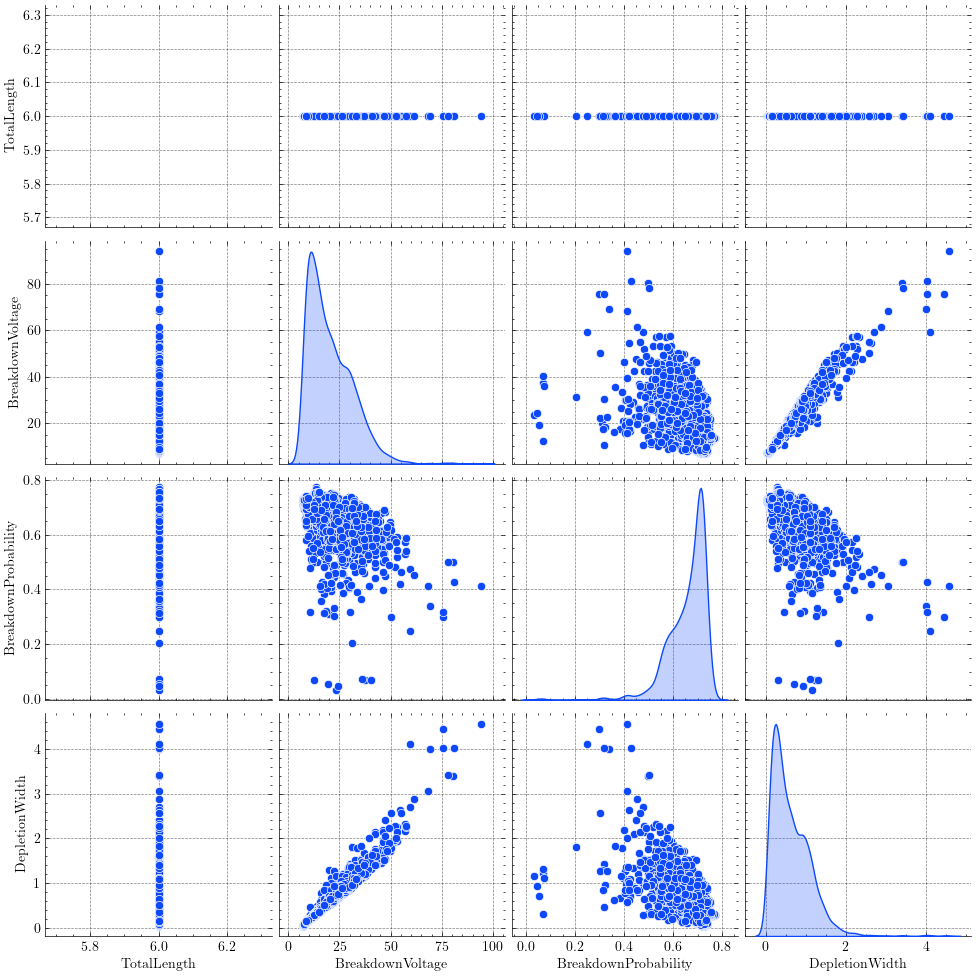

In [8]:
# Inspect the data
pp = sns.pairplot(train_dataset[["TotalLength", "BreakdownVoltage", "BreakdownProbability", "DepletionWidth"]], diag_kind="kde")
plt.show()

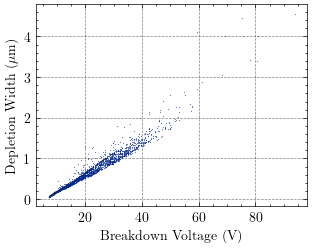

In [24]:
fig, axs = plt.subplots(1, 1)
axs.scatter(train_dataset["BreakdownVoltage"], train_dataset["DepletionWidth"], s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
axs.set_xlabel("Breakdown Voltage (V)")
axs.set_ylabel("Depletion Width ($\mu$m)")
fig.savefig("BreakdownVoltage_vs_DepletionWidth_MC_Sampling.png", dpi=300)
fig.savefig("BreakdownVoltage_vs_DepletionWidth_MC_Sampling.pdf", dpi=300)
plt.show()

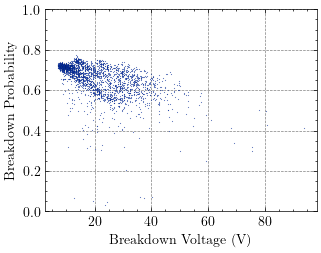

In [25]:
fig, axs = plt.subplots(1, 1)
axs.scatter(train_dataset["BreakdownVoltage"], train_dataset["BreakdownProbability"], s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
axs.set_xlabel("Breakdown Voltage (V)")
axs.set_ylabel("Breakdown Probability")
axs.set_ylim(0, 1)
fig.savefig("BreakdownVoltage_vs_BreakdownProbability_MC_Sampling.png", dpi=300)
fig.savefig("BreakdownVoltage_vs_BreakdownProbability_MC_Sampling.pdf", dpi=300)

plt.show()

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TotalLength,2498.0,6.000000,0.000000,6.000000,6.000000,6.000000,6.000000,6.000000
Donor_0,2498.0,17.954032,1.134791,16.002166,17.000226,17.920905,18.929930,19.997648
Donor_1,2498.0,17.954032,1.134791,16.002166,17.000226,17.920905,18.929930,19.997648
Donor_2,2498.0,17.954032,1.134791,16.002166,17.000226,17.920905,18.929930,19.997648
Donor_3,2498.0,17.954032,1.134791,16.002166,17.000226,17.920905,18.929930,19.997648
...,...,...,...,...,...,...,...,...
Acceptors_98,2498.0,16.988366,1.105573,15.006894,16.040005,16.965666,17.957906,18.964778
Acceptors_99,2498.0,16.988324,1.095509,15.007321,16.054995,16.968740,17.946710,18.964684
BreakdownVoltage,2498.0,20.413908,10.685352,6.980000,11.866000,17.915000,27.222000,93.998000
BreakdownProbability,2498.0,0.657607,0.079177,0.034000,0.617000,0.681000,0.714000,0.773000


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

Labels_Features = ["BreakdownVoltage", "BreakdownProbability", "DepletionWidth"]

train_labels = train_features.pop(Labels_Features[0])
test_labels = test_features.pop(Labels_Features[0])

train_labels = train_features.pop(Labels_Features[1])
test_labels = test_features.pop(Labels_Features[1])

train_labels = train_features.pop(Labels_Features[2])
test_labels = test_features.pop(Labels_Features[2])

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
TotalLength,6.000000,0.000000
Donor_0,17.954032,1.134791
Donor_1,17.954032,1.134791
Donor_2,17.954032,1.134791
Donor_3,17.954032,1.134791
...,...,...
Acceptors_98,16.988366,1.105573
Acceptors_99,16.988324,1.095509
BreakdownVoltage,20.413908,10.685352
BreakdownProbability,0.657607,0.079177


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


[[ 5.999999 17.954033 17.954033 17.954033 17.954033 17.954033 17.954033
  17.954033 17.954033 17.954033 17.954033 17.954033 17.954033 17.954033
  17.954033 17.954033 17.954033 17.954033 17.954033 17.954033 17.954033
  17.954033 17.954033 17.954033 17.954033 17.954033 17.954033 17.954033
  17.954033 17.954033 17.954033 17.954033 17.954033 17.954033 14.964458
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11.999998
  11.999998 11.999998 11.999998 11.999998 11.999998 11.999998 11

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 201)              403       
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 202       
                                                                 
Total params: 605
Trainable params: 202
Non-trainable params: 403
_________________________________________________________________
1/1 [==============================] - 0s 26ms/step
Epoch 1/200
63/63 [==============================] - 0s 2ms/step - loss: 6.2929 - val_loss: 5.1414
Epoch 2/200
63/63 [==============================] - 0s 1ms/step - loss: 5.2247 - val_loss: 5.1303
Epoch 3/200
63/63 [==============================] - 0s 1ms/step - loss: 5.5680 - val_loss: 4.9819
Epoch 4/200
63/63 [================

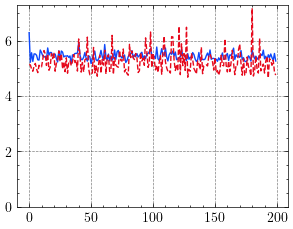

In [17]:
# First try with a simple linear model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

linear_model.predict(train_features[:10])
linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels_BV,
    epochs=200,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

fig, ax = plt.subplots()
plot_loss(history, ax)
ax.set_ylim(bottom=0.0)

plt.show()

In [74]:
# Regression with a deep neural network (Input size is 201)
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(2048, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'), 
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model



dnn_model_BV = build_and_compile_model(normalizer)
dnn_model_BV.summary()

history_BV = dnn_model_BV.fit(
    train_features, train_labels_BV,
    validation_split=0.2,
    verbose=1, epochs=250)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 201)              403       
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 2048)              413696    
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

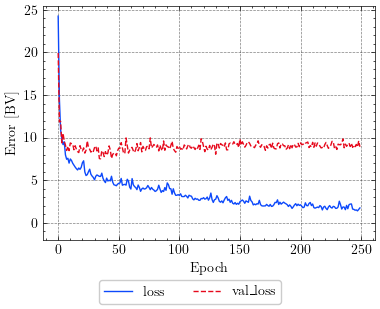

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BV, ax)
ax.set_ylim(bottom=-2.0)
# Inset zoom
# axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
# plot_loss(history_BV, axins)
# axins.set_xlim(history_BV.epoch[-1]-50, history_BV.epoch[-1])
# axins.set_ylim(0.0, 2.0)
# ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BV]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 1ms/step


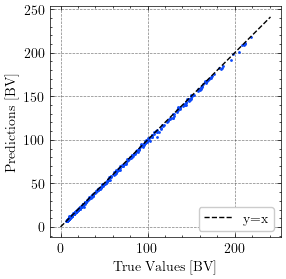

In [26]:
# Make predictions
test_predictions_BV = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BV, test_predictions_BV, s=1)
ax.set_xlabel('True Values [BV]')
ax.set_ylabel('Predictions [BV]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BV)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [27]:
history_BrP = dnn_model.fit(
    train_features, train_labels_BrP,
    validation_split=0.2,
    verbose=1, epochs=250)

Epoch 1/250
45/45 [==============================] - 0s 2ms/step - loss: 16.4645 - val_loss: 0.2339
Epoch 2/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1259 - val_loss: 0.1143
Epoch 3/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0937 - val_loss: 0.1049
Epoch 4/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0968
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0915
Epoch 6/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0884
Epoch 7/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0854
Epoch 8/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0839
Epoch 9/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0813
Epoch 10/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0785
Epoch 11

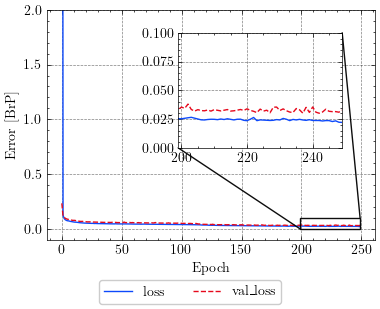

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BrP, ax)
ax.set_ylim(bottom=-0.10, top=2.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_BrP, axins)
axins.set_xlim(history_BrP.epoch[-1]-50, history_BrP.epoch[-1])
axins.set_ylim(0.0, 0.10)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BrP]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 940us/step


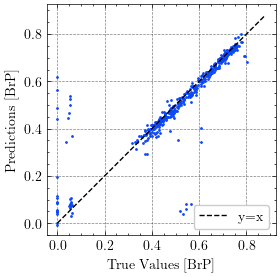

In [29]:
# Make predictions
test_predictions_BrP = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BrP, test_predictions_BrP, s=1)
ax.set_xlabel('True Values [BrP]')
ax.set_ylabel('Predictions [BrP]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BrP)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [30]:
history_DW = dnn_model.fit(
    train_features, train_labels_DW,
    validation_split=0.2,
    verbose=1, epochs=250)


Epoch 1/250
45/45 [==============================] - 0s 2ms/step - loss: 1.6676 - val_loss: 0.5357
Epoch 2/250
45/45 [==============================] - 0s 2ms/step - loss: 0.2620 - val_loss: 0.2662
Epoch 3/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1460 - val_loss: 0.1534
Epoch 4/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1367 - val_loss: 0.2053
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1238 - val_loss: 0.1106
Epoch 6/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.0939
Epoch 7/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0838 - val_loss: 0.0870
Epoch 8/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0838
Epoch 9/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.1031
Epoch 10/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0777
Epoch 11/

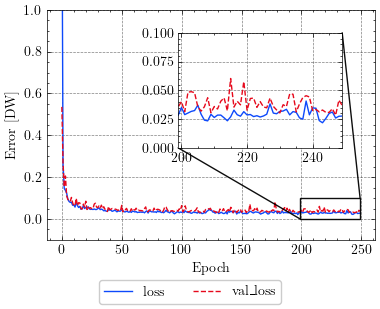

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_DW, ax)
ax.set_ylim(bottom=-0.10, top=1.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_DW, axins)
axins.set_xlim(history_DW.epoch[-1]-50, history_DW.epoch[-1])
axins.set_ylim(0.0, 0.1)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [DW]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 831us/step


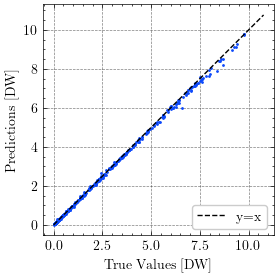

In [32]:
# Make predictions
test_predictions_DW = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_DW, test_predictions_DW, s=1)
ax.set_xlabel('True Values [DW]')
ax.set_ylabel('Predictions [DW]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_DW)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()
